In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, cm
import kmapper as km
import graphviz as gz
import itertools
import colorsys
import sklearn

np.random.seed(1234)

%matplotlib inline

In [2]:
df=pd.read_csv("DetailedPlayerStats.csv", encoding='ANSI')
df.head()

C:\Users\creme\Anaconda3\envs\px_stat\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,WebName,FirstName,SecondName,DreamTeam,SelectedBy,Position,Team,FixtureWeek1,Opponent1,...,Tackles,AttemptedPasses,PassesCompleted,BigChancesMissed,ErrorsToGoal,ErrorsToGoalAttempt,Tackled,Offside,Fouls,Dribbles
0,1.0,Ospina,David,Ospina,False,0.2,Goalkeeper,Arsenal,Gameweek 34,Newcastle,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Ospina,David,Ospina,False,0.2,Goalkeeper,Arsenal,Gameweek 34,Newcastle,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,Ospina,David,Ospina,False,0.2,Goalkeeper,Arsenal,Gameweek 34,Newcastle,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,Ospina,David,Ospina,False,0.2,Goalkeeper,Arsenal,Gameweek 34,Newcastle,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,Ospina,David,Ospina,False,0.2,Goalkeeper,Arsenal,Gameweek 34,Newcastle,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.columns

Index(['Id', 'WebName', 'FirstName', 'SecondName', 'DreamTeam', 'SelectedBy',
       'Position', 'Team', 'FixtureWeek1', 'Opponent1', 'HomeAway1',
       'FixtureWeek2', 'Opponent2', 'HomeAway2', 'FixtureWeek3', 'Opponent3',
       'HomeAway3', 'GameWeek', 'Points', 'Cost', 'NetTransfers',
       'MinutesPlayed', 'Goals', 'Assists', 'CleanSheet', 'Bonus',
       'YellowCards', 'RedCards', 'GoalsConceded', 'Crosses',
       'BigChancesCreated', 'ClearancesBlocksIntercepts', 'Recoveries',
       'KeyPasses', 'Tackles', 'AttemptedPasses', 'PassesCompleted',
       'BigChancesMissed', 'ErrorsToGoal', 'ErrorsToGoalAttempt', 'Tackled',
       'Offside', 'Fouls', 'Dribbles'],
      dtype='object')

In [4]:
to_drop = ['Id', 'FirstName', 'SecondName', 'DreamTeam', 'SelectedBy',
       'Position', 'Team', 'FixtureWeek1', 'Opponent1', 'HomeAway1',
       'FixtureWeek2', 'Opponent2', 'HomeAway2', 'FixtureWeek3', 'Opponent3',
       'HomeAway3', 'GameWeek', 'Cost', 'NetTransfers']
features = [col for col in df.columns if col not in to_drop]
df = df[features]
df.columns

Index(['WebName', 'Points', 'MinutesPlayed', 'Goals', 'Assists', 'CleanSheet',
       'Bonus', 'YellowCards', 'RedCards', 'GoalsConceded', 'Crosses',
       'BigChancesCreated', 'ClearancesBlocksIntercepts', 'Recoveries',
       'KeyPasses', 'Tackles', 'AttemptedPasses', 'PassesCompleted',
       'BigChancesMissed', 'ErrorsToGoal', 'ErrorsToGoalAttempt', 'Tackled',
       'Offside', 'Fouls', 'Dribbles'],
      dtype='object')

In [5]:
g=df.groupby(u'WebName')
df2=g.aggregate(np.mean)
df2.head()

,Points,MinutesPlayed,Goals,Assists,CleanSheet,Bonus,YellowCards,RedCards,GoalsConceded,Crosses,...,Tackles,AttemptedPasses,PassesCompleted,BigChancesMissed,ErrorsToGoal,ErrorsToGoalAttempt,Tackled,Offside,Fouls,Dribbles
WebName,,,,,,,,,,,,,,,,,,,,,
Aarons,0.15625,4.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.031250,...,0.125000,1.281250,0.875000,0.000000,0.000000,0.000000,0.250000,0.031250,0.031250,0.125000
Abraham,2.53125,49.468750,0.156250,0.093750,0.125000,0.343750,0.000000,0.000000,0.906250,0.031250,...,0.218750,8.906250,6.156250,0.125000,0.000000,0.000000,1.968750,0.250000,0.437500,0.812500
Adam,0.30303,12.272727,0.000000,0.000000,0.060606,0.000000,0.060606,0.030303,0.272727,0.181818,...,0.090909,7.424242,4.787879,0.030303,0.030303,0.030303,0.151515,0.000000,0.242424,0.333333
Adam Smith,1.69697,62.636364,0.030303,0.090909,0.060606,0.090909,0.181818,0.000000,1.151515,0.363636,...,0.848485,27.272727,22.545455,0.000000,0.000000,0.000000,0.969697,0.030303,0.696970,0.848485
Adarabioyo,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
df2.describe()

,Points,MinutesPlayed,Goals,Assists,CleanSheet,Bonus,YellowCards,RedCards,GoalsConceded,Crosses,...,Tackles,AttemptedPasses,PassesCompleted,BigChancesMissed,ErrorsToGoal,ErrorsToGoalAttempt,Tackled,Offside,Fouls,Dribbles
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,...,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,1.350845,32.213366,0.043877,0.039299,0.107396,0.104787,0.049378,0.001718,0.488977,0.090991,...,0.270101,14.713883,11.581061,0.032924,0.005243,0.009432,0.524009,0.069610,0.338840,0.317568
std,1.357213,29.304038,0.097014,0.070455,0.117102,0.159544,0.062918,0.007421,0.462659,0.154125,...,0.319000,15.721768,13.219802,0.073055,0.016333,0.022205,0.741553,0.156641,0.380249,0.487391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.062500,1.369318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.600379,0.468750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.093750,30.750000,0.000000,0.000000,0.090909,0.020833,0.030303,0.000000,0.406250,0.000000,...,0.156250,11.625000,8.107692,0.000000,0.000000,0.000000,0.187500,0.000000,0.218750,0.093750
75%,2.261364,55.197443,0.060606,0.060606,0.181818,0.156250,0.090909,0.000000,0.812500,0.125000,...,0.454545,24.092330,18.423059,0.031250,0.000000,0.000000,0.784564,0.062500,0.593750,0.437500
max,8.272727,90.000000,0.878788,0.531250,0.500000,0.857143,0.272727,0.062500,1.757576,0.818182,...,1.909091,90.187500,82.781250,0.606061,0.187500,0.156250,4.545455,1.062500,2.125000,4.156250


In [7]:
df2[ df2['Points'] > 5 ]

,Points,MinutesPlayed,Goals,Assists,CleanSheet,Bonus,YellowCards,RedCards,GoalsConceded,Crosses,...,Tackles,AttemptedPasses,PassesCompleted,BigChancesMissed,ErrorsToGoal,ErrorsToGoalAttempt,Tackled,Offside,Fouls,Dribbles
WebName,,,,,,,,,,,,,,,,,,,,,
Agüero,5.281250,61.250000,0.656250,0.187500,0.406250,0.687500,0.062500,0.0,0.375000,0.187500,...,0.156250,19.656250,16.250000,0.406250,0.0,0.0,2.250000,0.500000,0.312500,1.718750
Aubameyang,6.428571,87.142857,0.857143,0.142857,0.285714,0.857143,0.000000,0.0,1.142857,0.142857,...,0.428571,18.714286,13.714286,0.571429,0.0,0.0,0.714286,1.000000,0.142857,0.857143
De Bruyne,5.906250,83.593750,0.218750,0.531250,0.500000,0.781250,0.031250,0.0,0.625000,0.718750,...,0.781250,73.687500,61.718750,0.093750,0.0,0.0,2.031250,0.062500,0.843750,1.687500
Eriksen,5.531250,83.687500,0.312500,0.281250,0.468750,0.718750,0.000000,0.0,0.750000,0.593750,...,0.593750,58.562500,48.218750,0.062500,0.0,0.0,2.656250,0.031250,0.375000,0.687500
Firmino,5.030303,72.212121,0.424242,0.242424,0.393939,0.818182,0.030303,0.0,0.878788,0.151515,...,1.090909,30.181818,21.757576,0.151515,0.0,0.0,2.515152,0.303030,1.545455,1.333333
Kane,5.656250,79.375000,0.750000,0.062500,0.406250,0.843750,0.156250,0.0,0.781250,0.093750,...,0.375000,16.906250,12.218750,0.468750,0.0,0.0,3.031250,1.062500,0.968750,1.218750
Mahrez,5.187500,75.250000,0.312500,0.343750,0.250000,0.562500,0.031250,0.0,1.125000,0.312500,...,0.343750,32.875000,26.031250,0.125000,0.0,0.0,3.656250,0.312500,0.625000,2.062500
Salah,8.272727,74.818182,0.878788,0.333333,0.363636,0.787879,0.000000,0.0,0.818182,0.363636,...,0.181818,25.151515,19.515152,0.545455,0.0,0.0,3.636364,0.484848,0.424242,2.030303
Son,5.031250,62.437500,0.375000,0.187500,0.375000,0.500000,0.000000,0.0,0.468750,0.125000,...,0.281250,25.406250,21.687500,0.250000,0.0,0.0,2.375000,0.750000,0.406250,1.781250


In [8]:
df2 = df2[df2['MinutesPlayed'] > 0]
df2.describe()

,Points,MinutesPlayed,Goals,Assists,CleanSheet,Bonus,YellowCards,RedCards,GoalsConceded,Crosses,...,Tackles,AttemptedPasses,PassesCompleted,BigChancesMissed,ErrorsToGoal,ErrorsToGoalAttempt,Tackled,Offside,Fouls,Dribbles
count,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,...,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,1.701786,40.582200,0.055276,0.049508,0.135296,0.132009,0.062206,0.002164,0.616011,0.114630,...,0.340272,18.536459,14.589750,0.041477,0.006605,0.011883,0.660143,0.087695,0.426868,0.400070
std,1.312670,27.238798,0.105974,0.075826,0.116190,0.168759,0.064727,0.008273,0.437450,0.164994,...,0.322995,15.508627,13.276771,0.079818,0.018089,0.024336,0.776533,0.171274,0.380232,0.516058
min,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.575758,14.600000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.062500,5.272727,3.848485,0.000000,0.000000,0.000000,0.062500,0.000000,0.093750,0.060606
50%,1.625000,42.033333,0.000000,0.030303,0.121212,0.090909,0.034483,0.000000,0.593750,0.031250,...,0.281250,16.151515,11.666667,0.000000,0.000000,0.000000,0.375000,0.030303,0.363636,0.200000
75%,2.454545,60.454545,0.062500,0.062500,0.212121,0.187500,0.093750,0.000000,0.909091,0.156250,...,0.531250,26.787879,20.536585,0.060606,0.000000,0.015385,1.030303,0.090909,0.636364,0.545455
max,8.272727,90.000000,0.878788,0.531250,0.500000,0.857143,0.272727,0.062500,1.757576,0.818182,...,1.909091,90.187500,82.781250,0.606061,0.187500,0.156250,4.545455,1.062500,2.125000,4.156250


In [9]:
df2 = df2[[col for col in df2.columns if col not in ['Bonus']]]
names = df2.index.values

X = df2[[col for col in df2.columns if col not in ['Points']]]
X.index = [i for i in range(X.shape[0])]

(array([151.,  94., 121.,  66.,  30.,  13.,   7.,   2.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

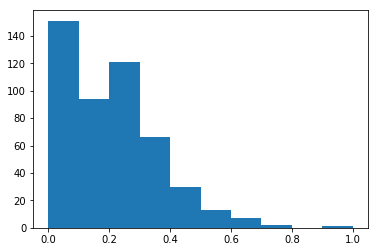

In [10]:
mapper = km.KeplerMapper(verbose=0)
lens = mapper.fit_transform(df2.values, 
                            # projection=sklearn.manifold.TSNE()
                            projection=[0])
plt.hist(lens)

In [11]:
graph = mapper.map(lens, X.values, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=10, random_state=1234),
                   # clusterer=sklearn.cluster.DBSCAN(eps=0.3, min_samples=1),
                   nr_cubes=30, overlap_perc=0.8)

In [12]:
node_dict = {}
for node in graph['nodes']:
    players = [names[i] for i in graph['nodes'][node]]
    node_dict[node] = players

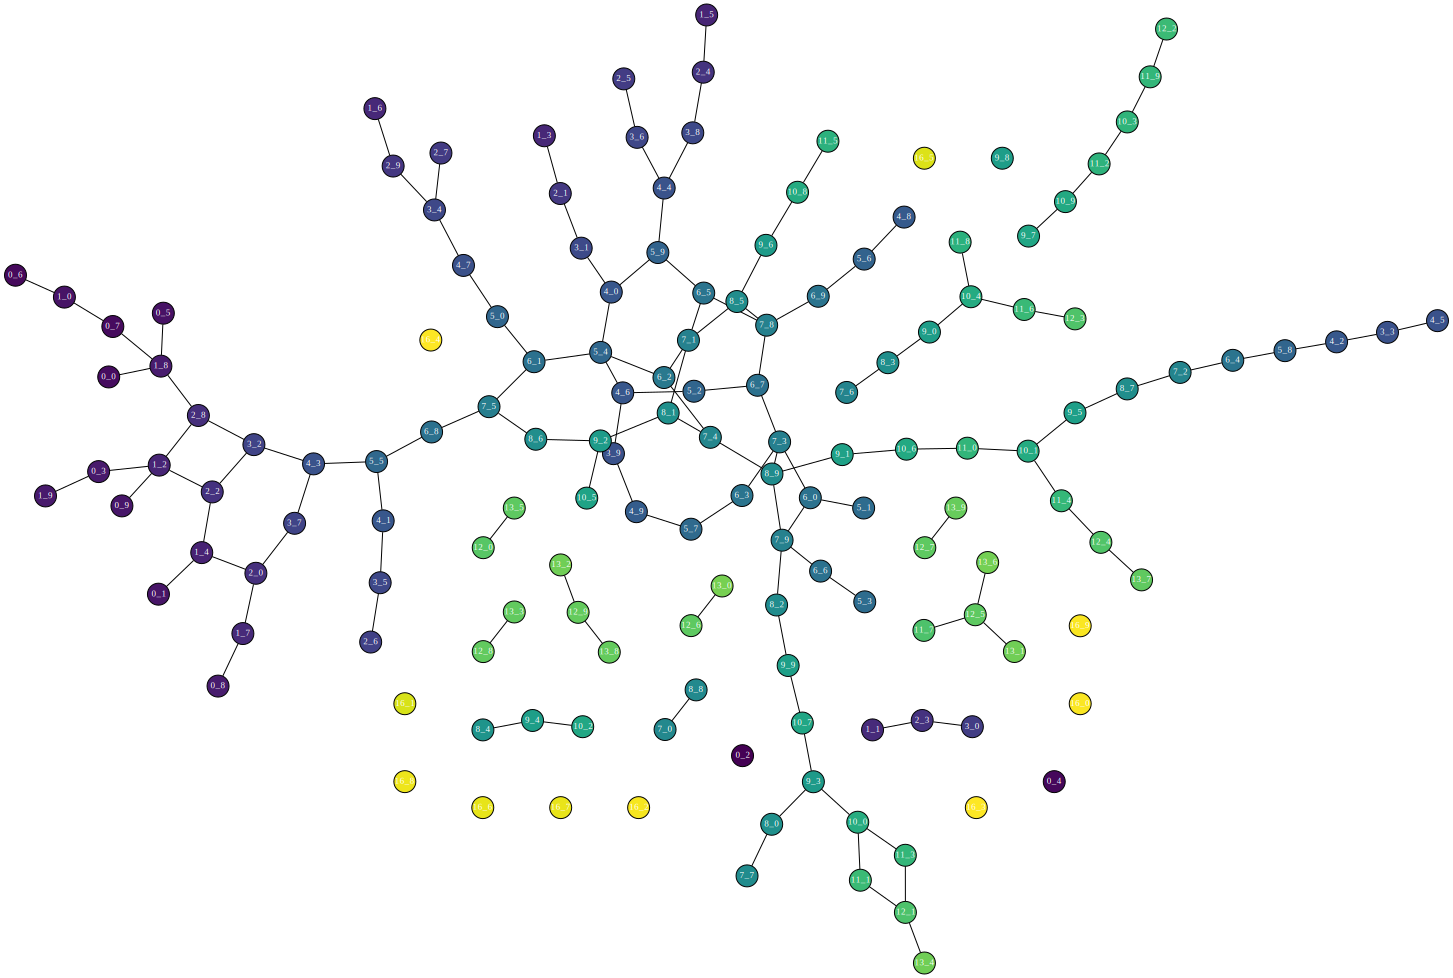

In [14]:
network=gz.Graph()
network.attr(layout='neato')
network.attr('edge', len='0.7')
network.attr('node', shape='circle', fixedsize='true', width='0.3', \
             label=None, fontsize='9', style='filled', fontcolor='white')

for node in graph['links']:
    for nbr in graph['links'][node]:
        # We'll remove the 'cube' and 'cluster' strings from the label to avoid clutter
        node=str.replace(str.replace(node,'cube',''),'cluster','')
        nbr=str.replace(str.replace(nbr,'cube',''),'cluster','')
        network.edge(node, nbr)
        
# Label the nodes and colour based on the average value of points in the cluster
nodes = []
for node in graph['nodes']:
    avg_pts=np.average([df2.iloc[i]['Points'] for i in graph['nodes'][node]])
    nodes.append(avg_pts)
    
norm = colors.Normalize(vmin = min(nodes), vmax = max(nodes))
clrmap=cm.ScalarMappable(norm = norm, cmap = cm.viridis)

for node in graph['nodes']:
    avg_pts=np.average([df2.iloc[i]['Points'] for i in graph['nodes'][node]])
    color=clrmap.to_rgba(avg_pts)
    color=colorsys.rgb_to_hsv(color[0], color[1], color[2])
    node=str.replace(str.replace(node,'cube',''),'cluster','')
    network.node(node, fillcolor="%f, %f, %f" % (color[0], color[1], color[2]))
    
# Display the graph
network

In [15]:
%%capture
mapper.visualize(graph, path_html="premier_league_players.html",
                 title="Player Data", inverse_X=X.values, 
                 inverse_X_names=names,
                 custom_tooltips=names,
                 color_function=df2['Points'].values)